In [56]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [57]:
df = pd.read_csv("AirPassengers.csv").rename(columns={"Passengers": "y", "Month": "ds"})

In [58]:
df["ds"] = pd.to_datetime(df["ds"])
df['Month'] = df['ds'].dt.month
df['Year'] = df['ds'].dt.year

[Text(0.5, 1.0, 'Boxplot by Year Passengers'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Passengers')]

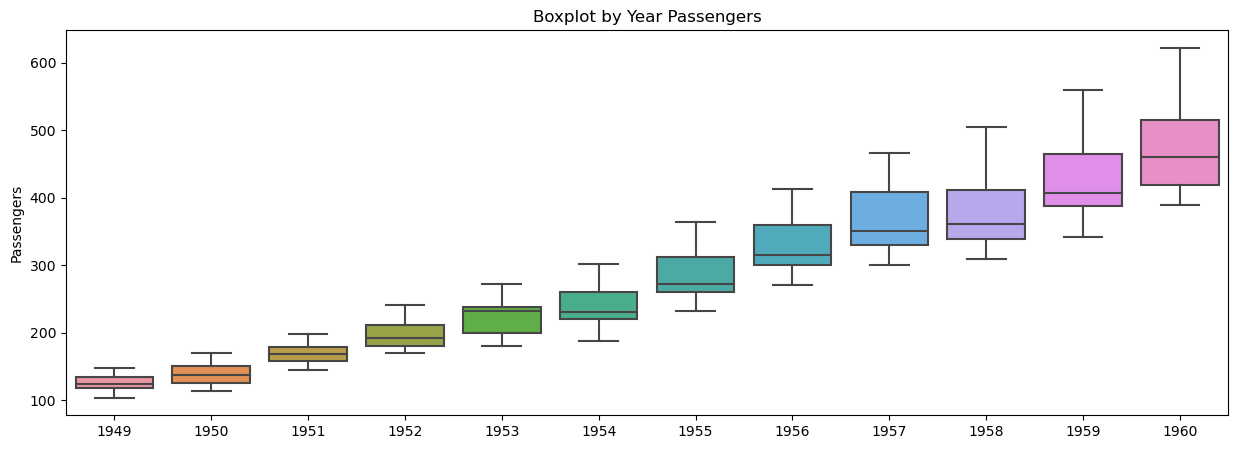

In [59]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="Year", y="y", data=df).set(title="Boxplot by Year Passengers", xlabel="", ylabel="Passengers")

[Text(0.5, 1.0, 'Boxplot by Month Passengers'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Passengers')]

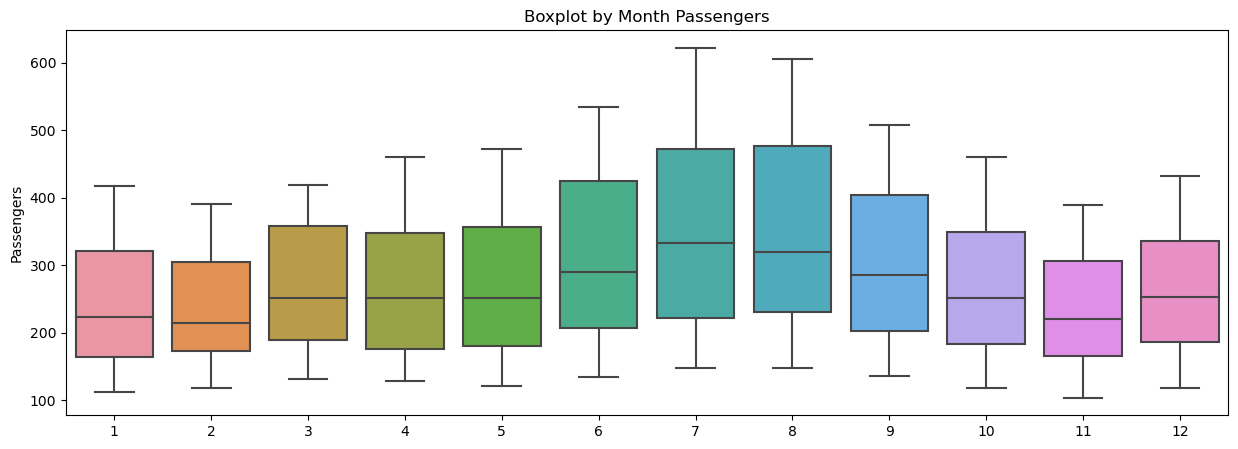

In [60]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="Month", y="y", data=df).set(title="Boxplot by Month Passengers", xlabel="", ylabel="Passengers")

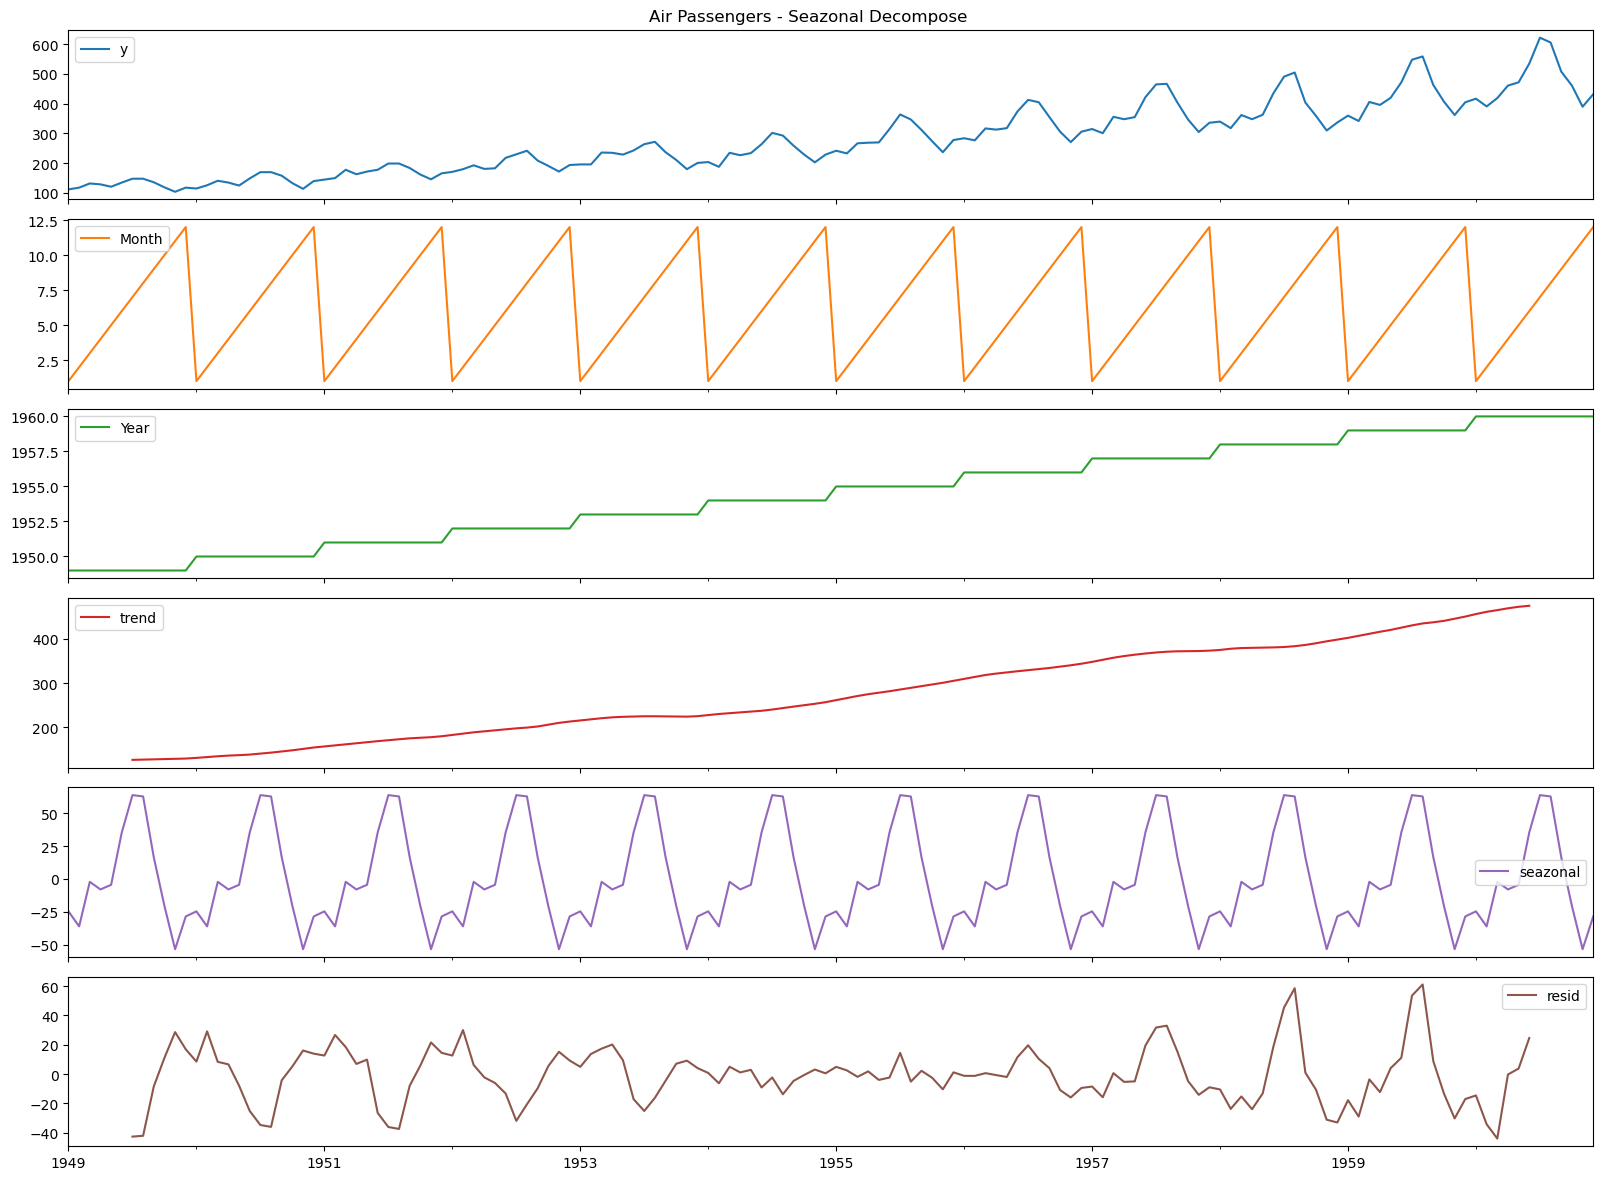

In [61]:
result = seasonal_decompose(df['y'], model='additive', period=12)
df['trend'] = result.trend
df['seazonal'] = result.seasonal
df['resid'] = result.resid

df.plot(x="ds", figsize=(16, 4*3), title="Air Passengers - Seazonal Decompose",xlabel="", subplots=True)
plt.tight_layout()

c:\Users\herbert.mariano\AppData\Local\anaconda3\envs\demanda_vendas\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


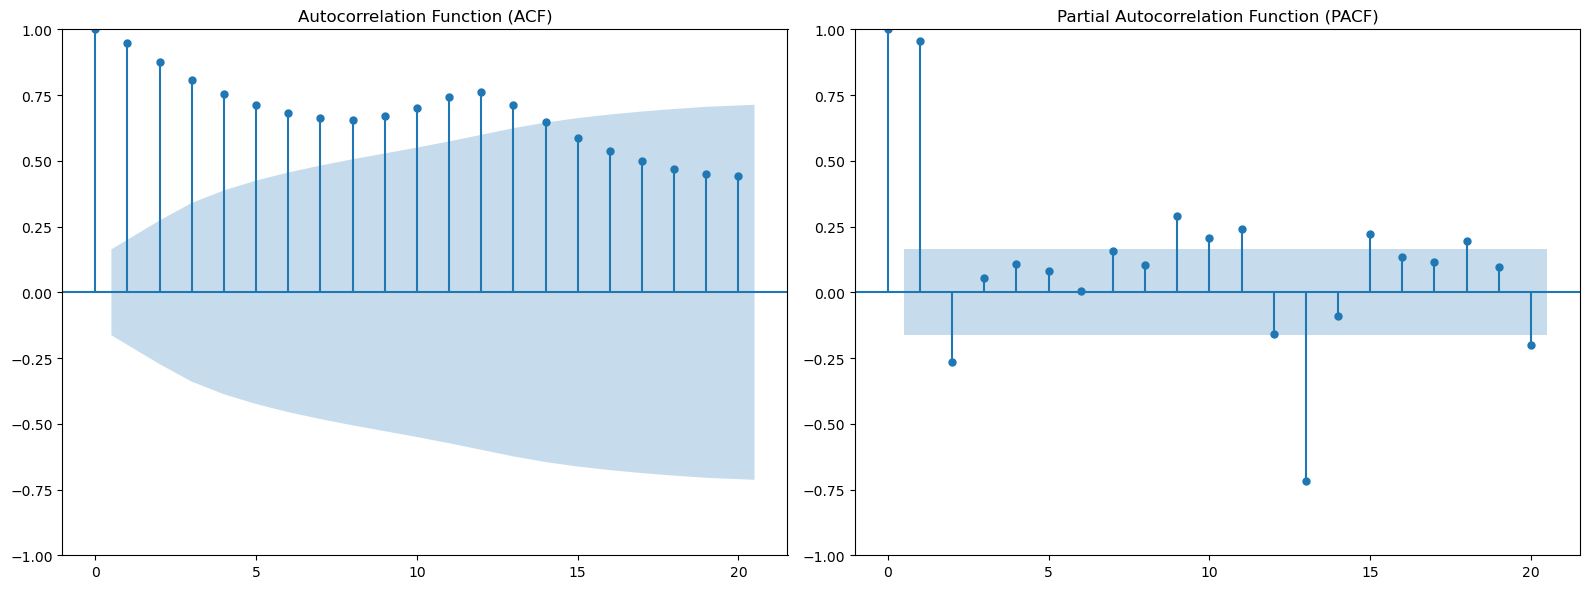

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(df['y'], lags=20, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(df['y'], lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Air Passengers Original Data'}, ylabel='Passengers'>

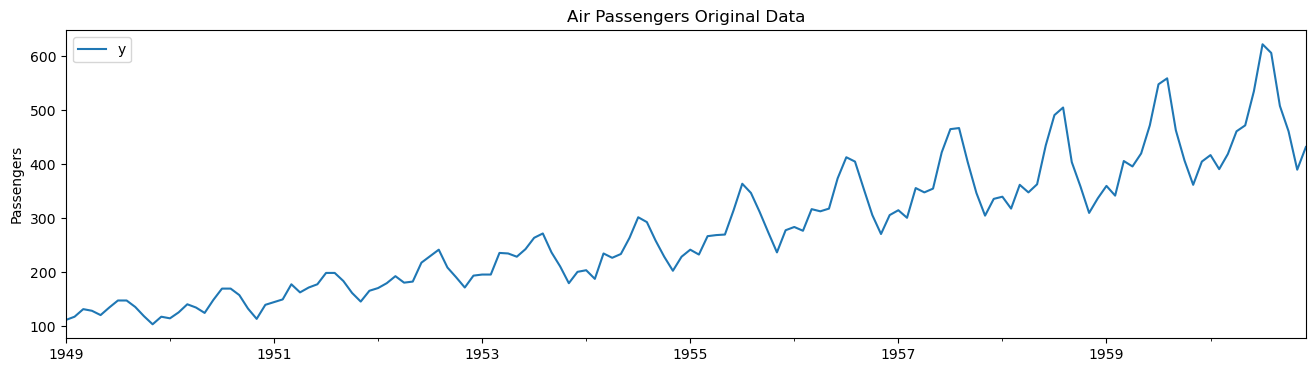

In [63]:
df.plot(x="ds", y="y", figsize=(16, 4), title="Air Passengers Original Data",xlabel="", ylabel="Passengers")

In [64]:
Q3 = result.resid.quantile(0.75)
Q1 = result.resid.quantile(0.25)
IQR = Q3-Q1
Limin = Q1-(IQR*1.5)    
Limsp = Q3+(IQR*1.5)
result.observed.loc[(result.resid < Limin) | (result.resid > Limsp)] = None
df['y'] = result.observed

<AxesSubplot:title={'center':'Air Passengers - After Outliers Filter'}, ylabel='Passengers'>

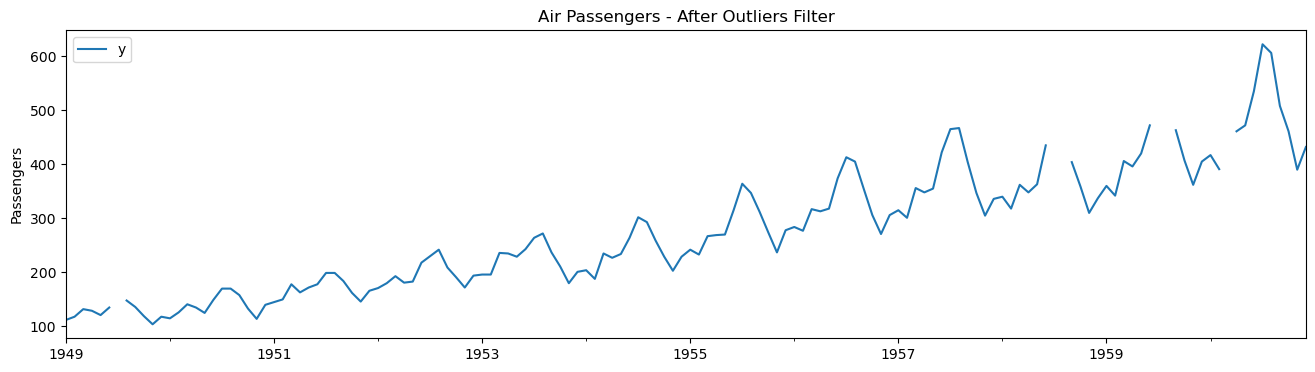

In [65]:
df.plot(x="ds", y="y", figsize=(16, 4), title="Air Passengers - After Outliers Filter",xlabel="", ylabel="Passengers")

In [66]:
df = df[['ds','y']]

In [69]:
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode':['additive', 'multiplicative'],
    'changepoint_range':[0.3,0.5,0.7,0.9],
    'growth':['linear'],
    'yearly_seasonality':[True],
}

cutoffs = pd.to_datetime(['1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06','1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12'])

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = pd.DataFrame()
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m,horizon='365 days',cutoffs=cutoffs, parallel="processes")
    results = pd.concat([results, df_cv.assign(labeled_params=str(params))], axis=0)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023A0ED95D30>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023A0ED95B70>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023A0ED5EFD0>
INFO:prophet:Disabling weekly seasonality. 

In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.abs((y_true - y_pred) / y_true) * 100

In [12]:
df_cv['APE'] = absolute_percentage_error(df_cv['y'], df_cv['yhat'])

[Text(0.5, 1.0, 'Absolute Percentage Error (APE) by Cutoff Date'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'APE')]

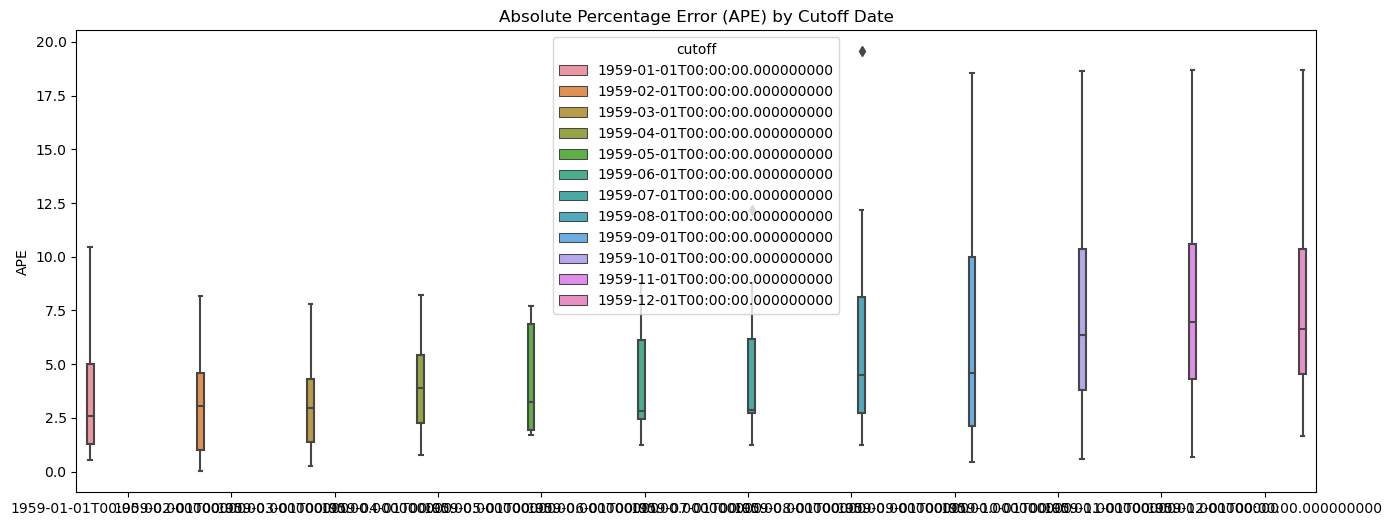

In [34]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="cutoff", y="APE", hue="cutoff", data=df_cv).set(title='Absolute Percentage Error (APE) by Cutoff Date',xlabel="", ylabel="APE")

cutoff
1959-01-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-02-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-03-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-04-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-05-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-06-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-07-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-08-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-09-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-10-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-11-01    AxesSubplot(0.125,0.2;0.775x0.68)
1959-12-01    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

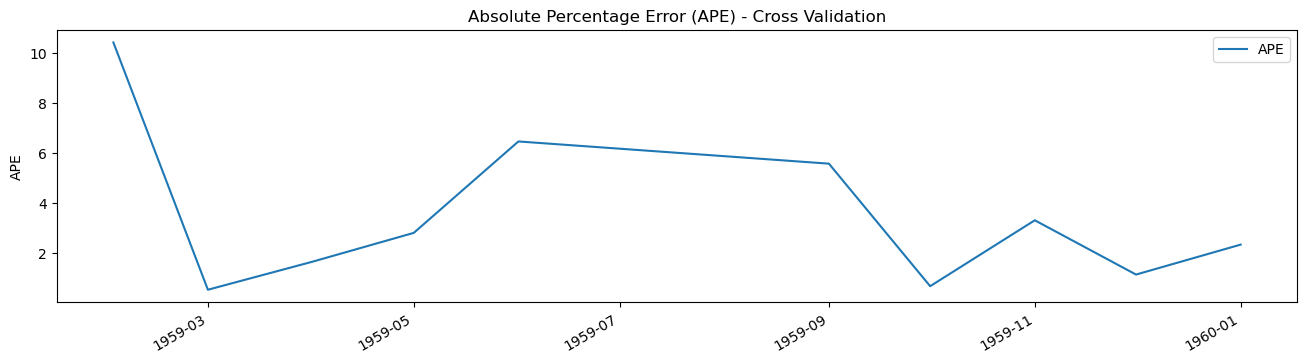

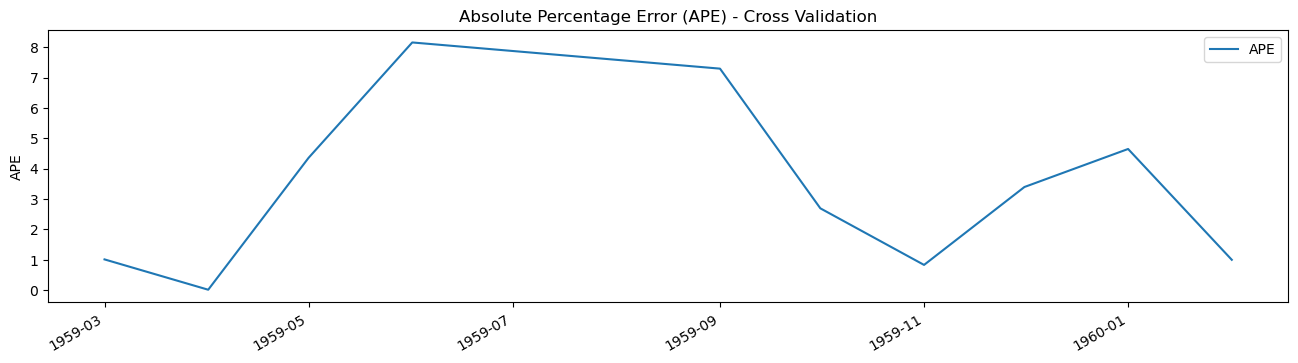

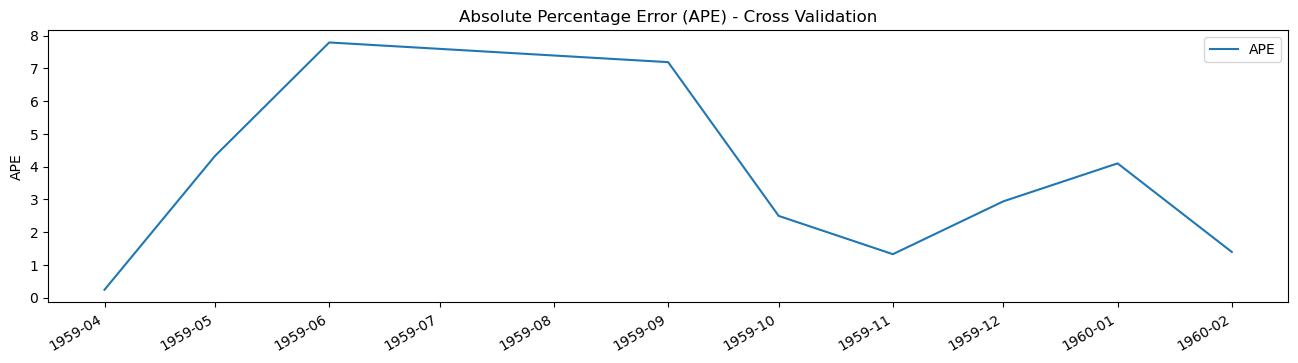

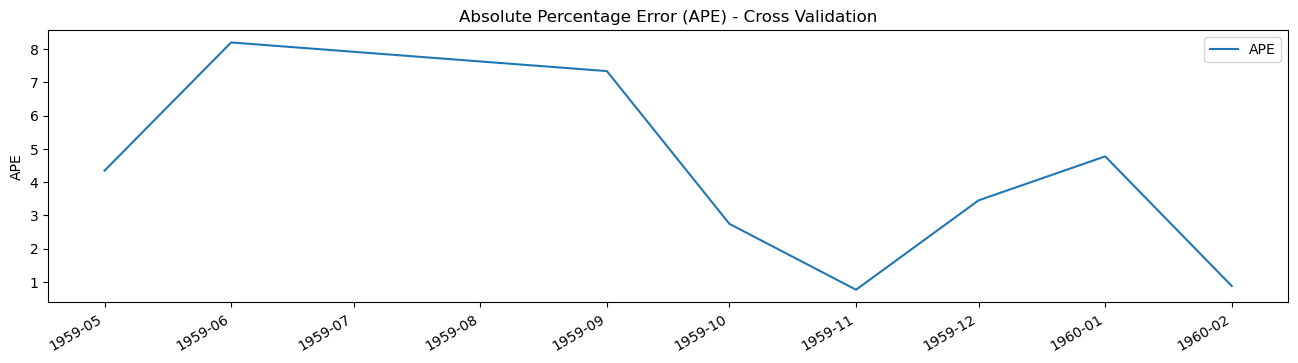

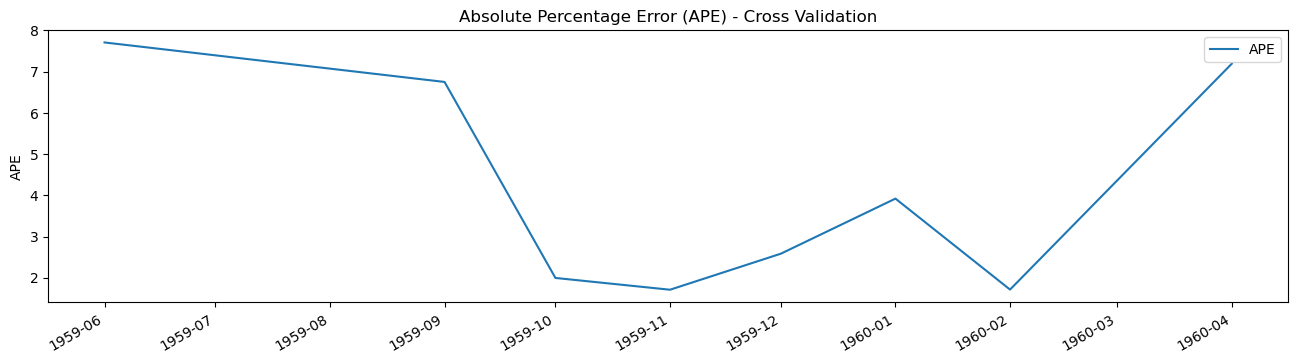

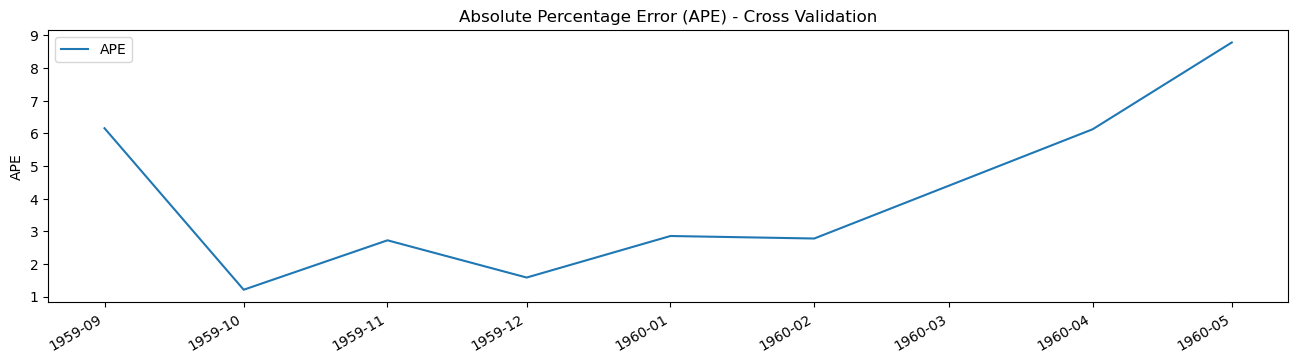

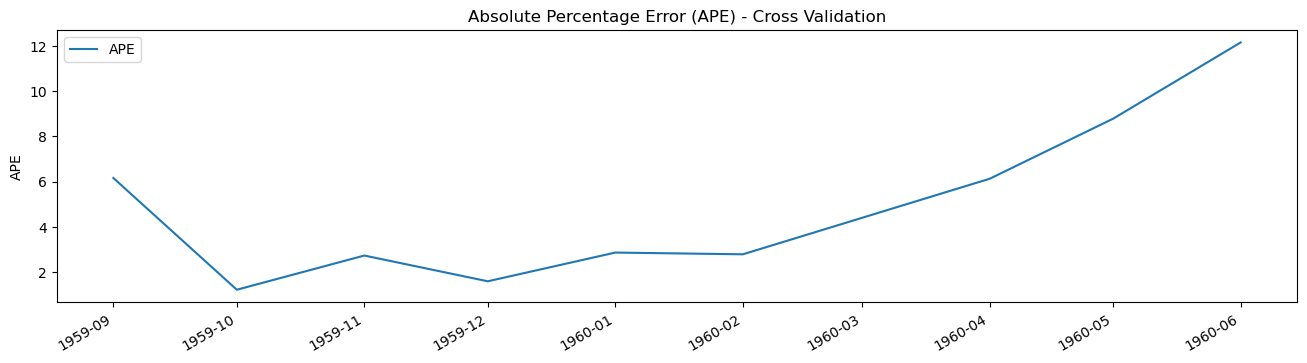

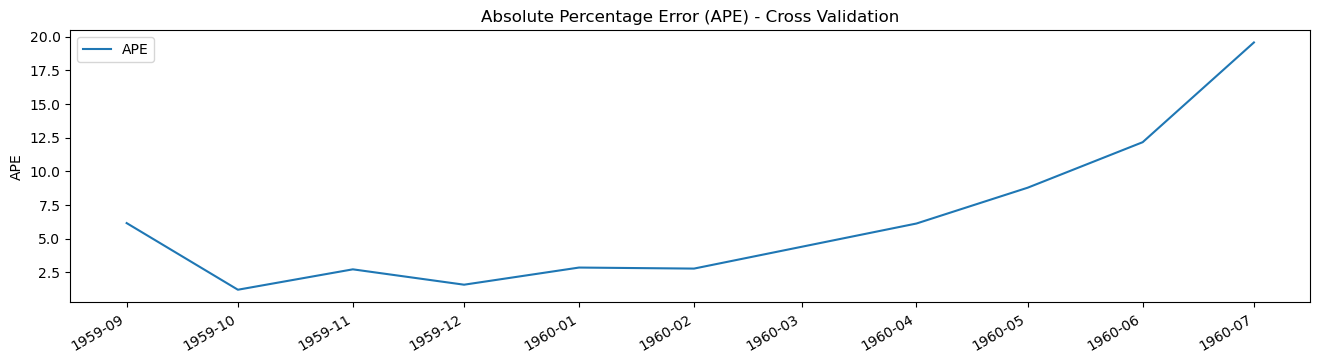

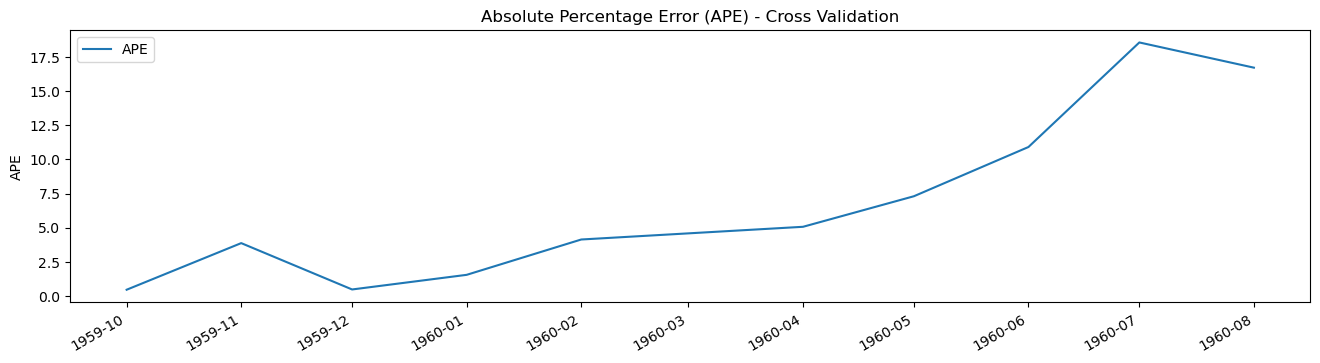

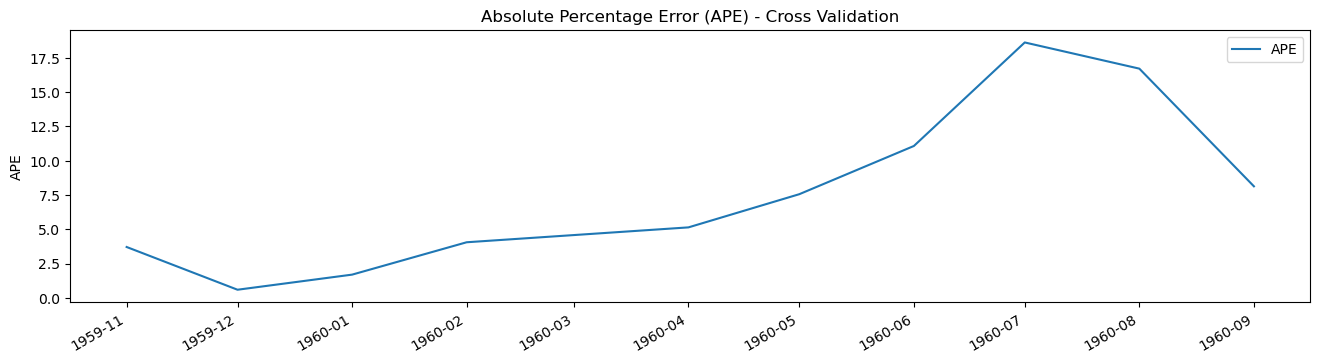

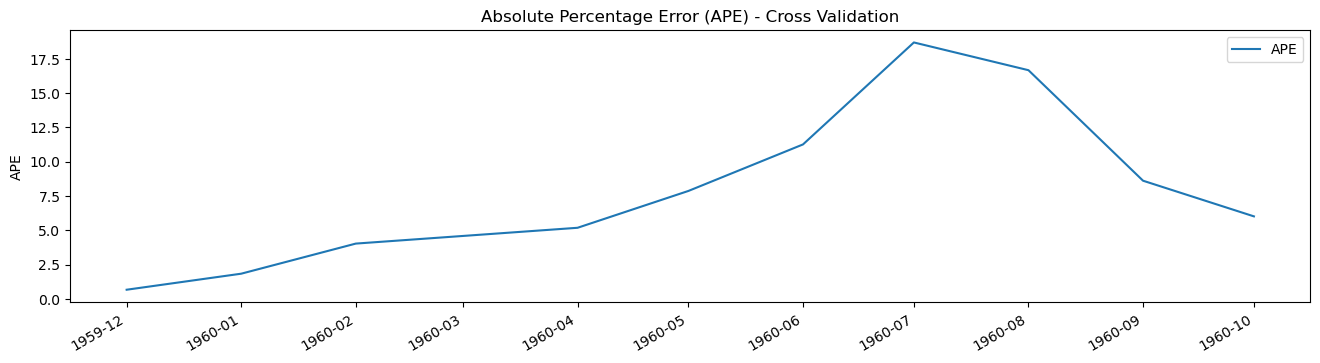

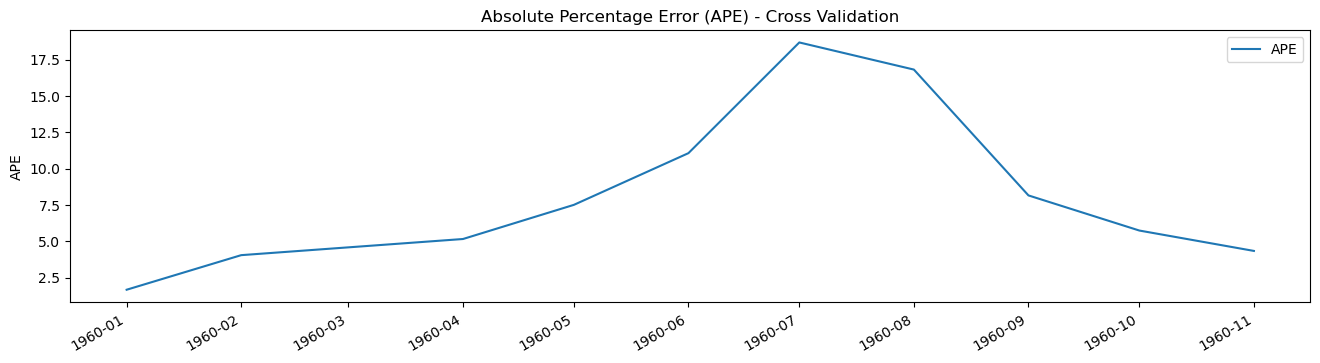

In [23]:
df_cv.groupby('cutoff').plot(x='ds', y='APE', figsize=(16, 4), title="Absolute Percentage Error (APE) - Cross Validation",xlabel="", ylabel="APE")

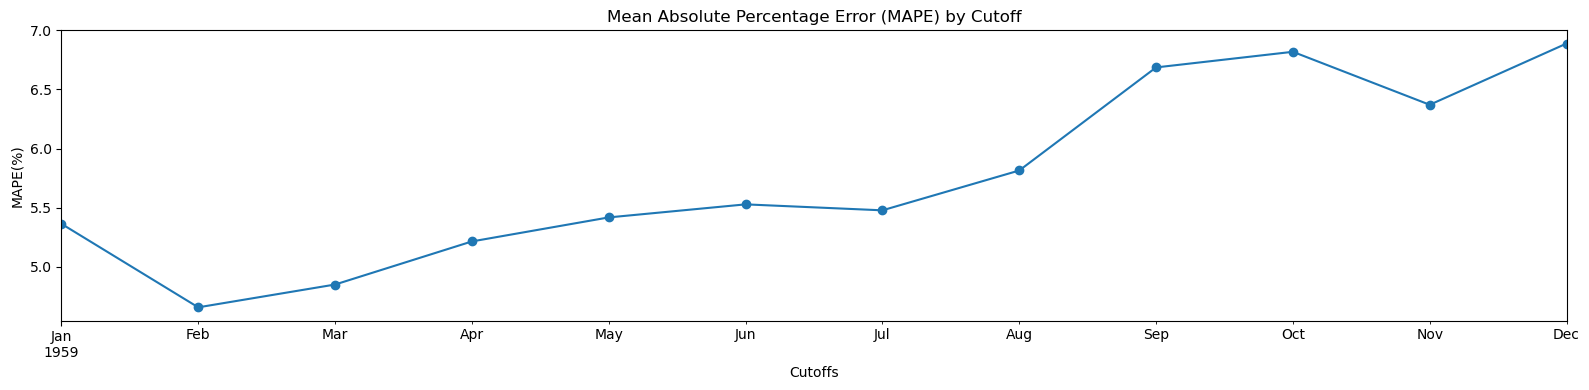

In [33]:
df_cv.groupby('cutoff').apply(lambda df: mean_absolute_percentage_error(df.y, df.yhat)).plot(marker='o',figsize=(16, 4), title="Mean Absolute Percentage Error (MAPE) by Cutoff", xlabel="Cutoffs", ylabel="MAPE(%)")
plt.tight_layout()

c:\Users\herbert.mariano\AppData\Local\anaconda3\envs\demanda_vendas\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
c:\Users\herbert.mariano\AppData\Local\anaconda3\envs\demanda_vendas\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


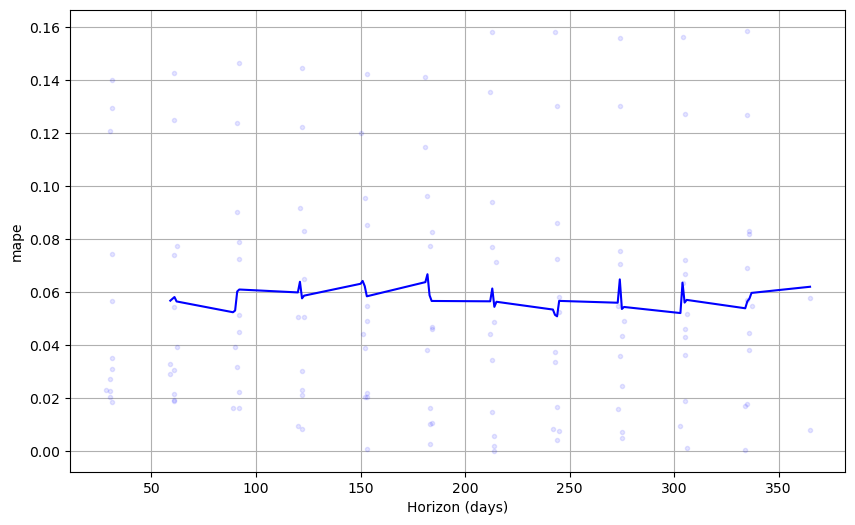

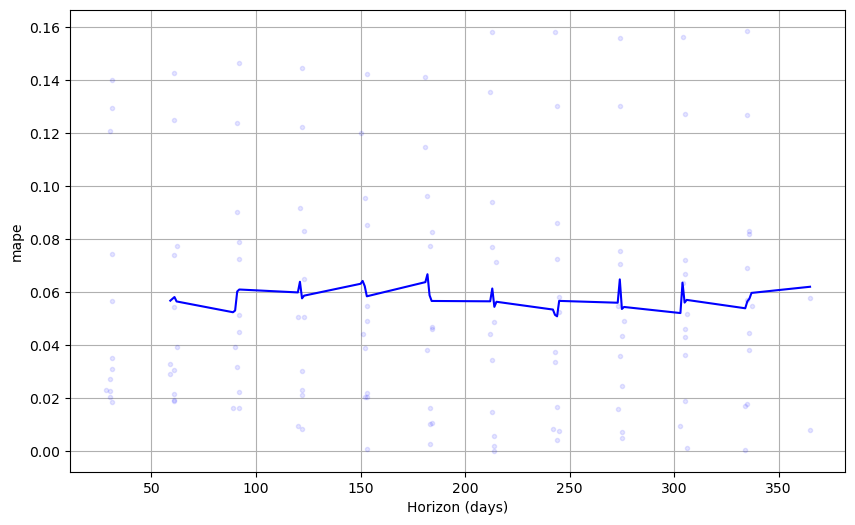

In [21]:
plot_cross_validation_metric(df_cv, metric='mape')

In [35]:
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

cutoffs = df['ds'].unique()[:-12][-12:]
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TypeError: cross_validation() missing 1 required positional argument: 'horizon'

In [36]:
pd.to_timedelta(4, unit="QS")

ValueError: invalid unit abbreviation: QS

In [34]:
pd.to_timedelta(12,unit="month")

ValueError: invalid unit abbreviation: month

In [7]:
for i in range(1, 4):  # Adjust the lag range as needed
    df[f'y_lag_{i}'] = df['y'].shift(i)

# Drop rows with NaN values resulting from the lag
df = df.dropna()

# Create and fit the Prophet model
model = p.Prophet()
model.add_regressor('y_lag_1')
model.add_regressor('y_lag_2')
model.add_regressor('y_lag_3')
model.fit(df)

# Create a dfFrame for future prediction with the same lag features
future = df[['ds', 'y_lag_1', 'y_lag_2', 'y_lag_3']].copy()
future = future.dropna()

# Make future predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.show()

AttributeError: 'Prophet' object has no attribute 'stan_backend'